### Exploratory Data Analysis & Feature Engineering

Objective:
    1. To get an insight into input dataframe.
    2. To get an understanding of basic statistics.
    3. Identify features of importance through VIF, PCA and / or Decision Trees

Assumptions:
    1. Only *.csv files are currently being read.
    2. Target columns are placed after the features in the *.csv
    3. Median imputing is performed where needed. Change it appropriately as needed.

In [1]:
# Import relevant libraries

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.options.display.width=None

import ppscore as pps

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from pca import pca
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA as SKLPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
# Dataset I/O definitions

PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"


In [4]:
# Pick the dataset to be analyzed & specify a prefix for output files and figures

for r, d, f in os.walk(PATH):
    for file in f:
        if file.endswith(".csv"):
            continue
    print(f)
nfiles = len(f)

userinp = int(input("Enter input file index:"))
while userinp > (nfiles-1):
    print(f)
    userinp = int(input("Enter input file index:"))
    continue

files = f[userinp]

FNAME = f"{PATH}\{files}"

PREFIX = input("Prefix for Output Files & Figures: ")
PREFIX = f"\{PREFIX}"

# Specify number of features and targets in the dataset

n_features = int(input("Enter the Number of Features in Dataset: "))
n_target = int(input("Enter the Number of Targets in Dataset: "))

['Dataset_CC_Default_23x1.csv', 'Dataset_Creditcard_Mod_17x0.csv', 'Dataset_Indian_Liver_Patient_10x1.csv', 'Dataset_Lower_Back_Pain_12x1.csv']
Enter input file index:3
Prefix for Output Files & Figures: Back_Pain_
Enter the Number of Features in Dataset: 12
Enter the Number of Targets in Dataset: 1


In [5]:
# Dataset Definition

df = pd.read_csv(f"{FNAME}")
df = df.round(decimals=4)
maxcol = len(df.columns)

DF_INFO = df.dtypes.to_frame('Data Type').reset_index()

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

pd.set_option('display.max_columns', len(collst))

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]


In [6]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [7]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.8056,10.6887,54.0000,37.1169,125.3911,-0.4025,0.7504,32.8112,12.0502,15.6586,-4.1370,39.6199,Normal
1,92.0263,35.3927,77.4170,56.6336,115.7235,58.0575,0.3024,30.0162,9.8318,11.2125,-19.2648,19.9972,Patient
2,63.7924,21.3453,66.0000,42.4471,119.5504,12.3826,0.6079,21.5605,8.0233,8.7268,-8.8423,34.5721,Normal
3,46.3903,11.0790,32.1366,35.3112,98.7745,6.3868,0.0649,14.2826,7.4515,7.3018,-24.3608,28.2366,Patient
4,64.6240,15.2253,67.6322,49.3987,90.2985,31.3264,0.7817,24.7626,18.5975,13.0176,-20.5263,17.3548,Patient


In [8]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue


In [9]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [10]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.8056,10.6887,54.0000,37.1169,125.3911,-0.4025,0.7504,32.8112,12.0502,15.6586,-4.1370,39.6199,0
1,92.0263,35.3927,77.4170,56.6336,115.7235,58.0575,0.3024,30.0162,9.8318,11.2125,-19.2648,19.9972,1
2,63.7924,21.3453,66.0000,42.4471,119.5504,12.3826,0.6079,21.5605,8.0233,8.7268,-8.8423,34.5721,0
3,46.3903,11.0790,32.1366,35.3112,98.7745,6.3868,0.0649,14.2826,7.4515,7.3018,-24.3608,28.2366,1
4,64.6240,15.2253,67.6322,49.3987,90.2985,31.3264,0.7817,24.7626,18.5975,13.0176,-20.5263,17.3548,1


In [11]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [12]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [13]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)


In [14]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [15]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'Direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']

List of Targets: ['Class_att']

List of Categorical Variables: ['Class_att']

List of Categorical Targets ['Class_att']



In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |    std |     min |     25% |     50% |     75% |     max |
|--------------------------|---------|---------|--------|---------|---------|---------|---------|---------|
| pelvic_incidence         |     310 |  60.497 | 17.237 |  26.148 |   46.43 |  58.691 |  72.878 | 129.834 |
| pelvic_tilt              |     310 |  17.543 | 10.008 |  -6.555 |  10.667 |  16.358 |   22.12 |  49.432 |
| lumbar_lordosis_angle    |     310 |  51.931 | 18.554 |      14 |      37 |  49.562 |      63 | 125.742 |
| sacral_slope             |     310 |  42.954 | 13.423 |  13.367 |  33.347 |  42.405 |  52.696 |  121.43 |
| pelvic_radius            |     310 | 117.921 | 13.317 |  70.083 | 110.709 | 118.268 | 125.468 | 163.071 |
| degree_spondylolisthesis |     310 |  26.297 | 37.559 | -11.058 |   1.604 |  11.768 |  41.287 | 418.543 |
| pelvic_slope             |     310 |   0.473 |  0.286 |   0.003 |   0.224 |   0.476 |   0.705 |   0.999 |
| Direct_tilt              |

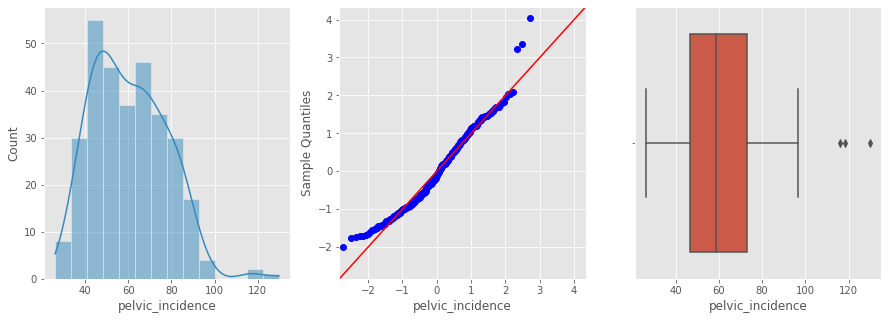

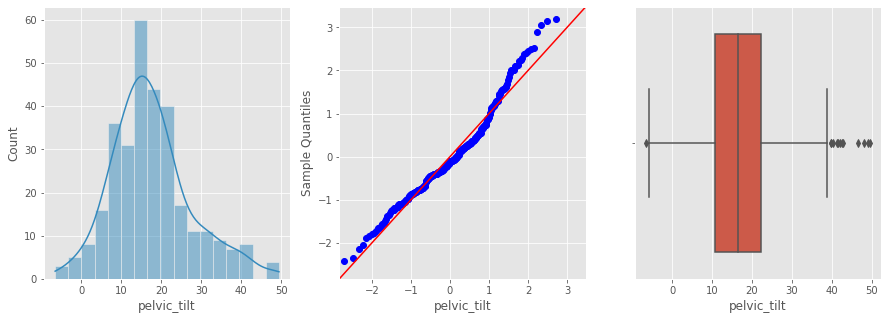

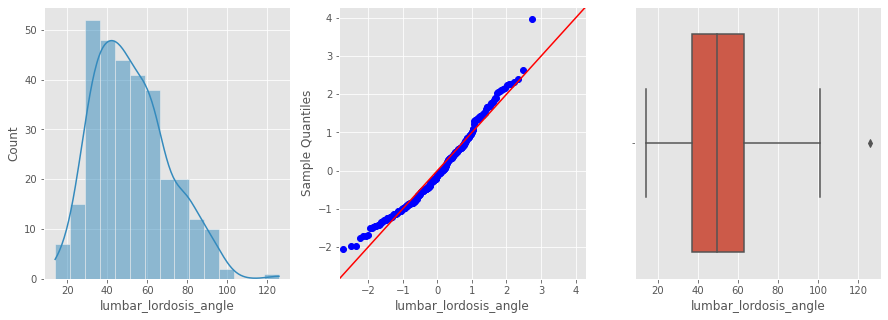

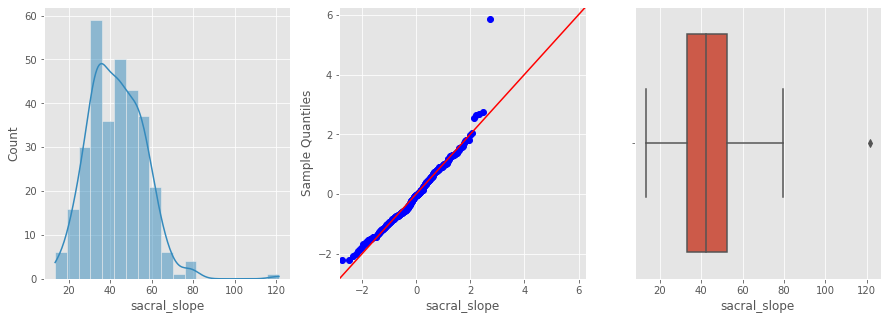

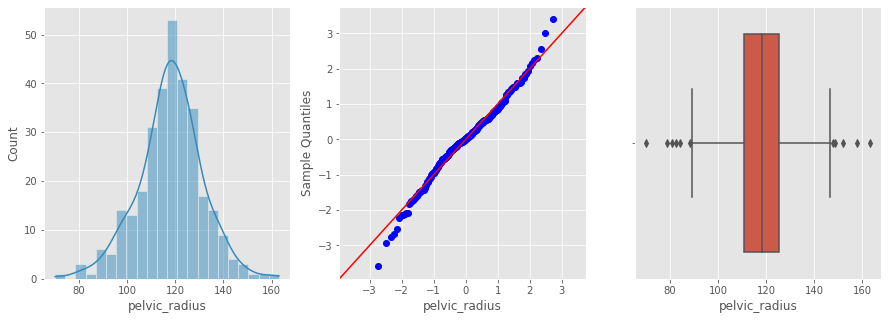

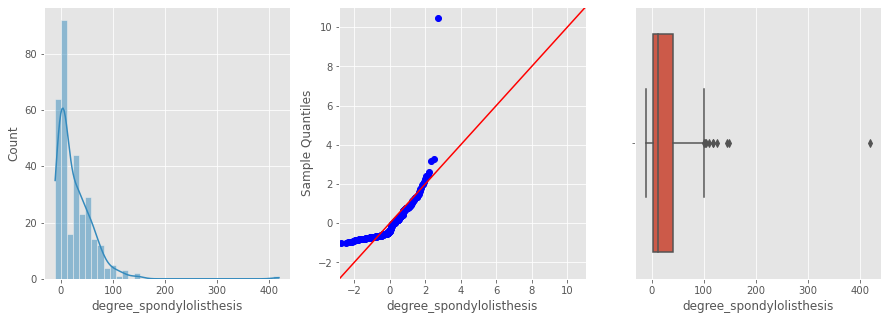

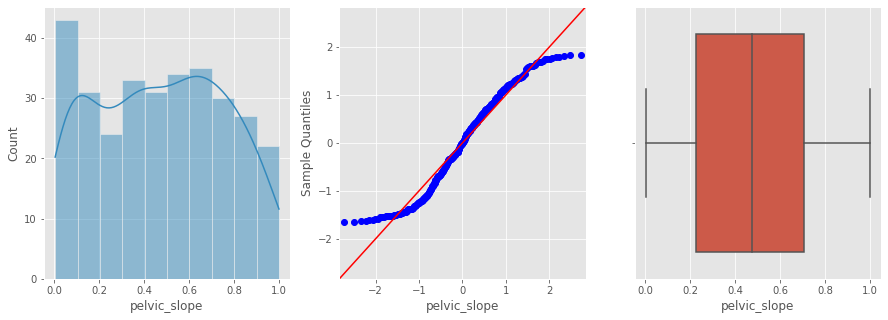

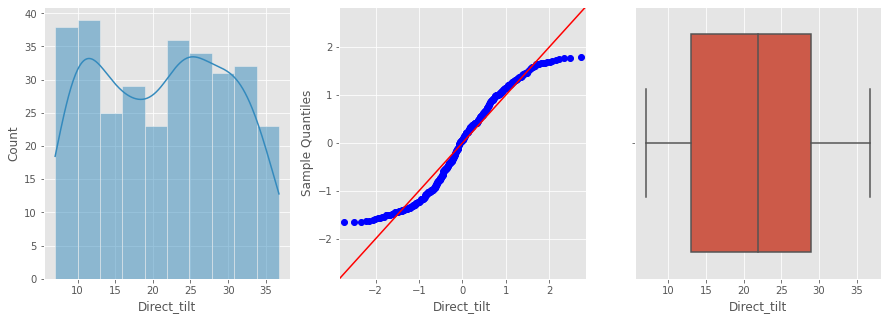

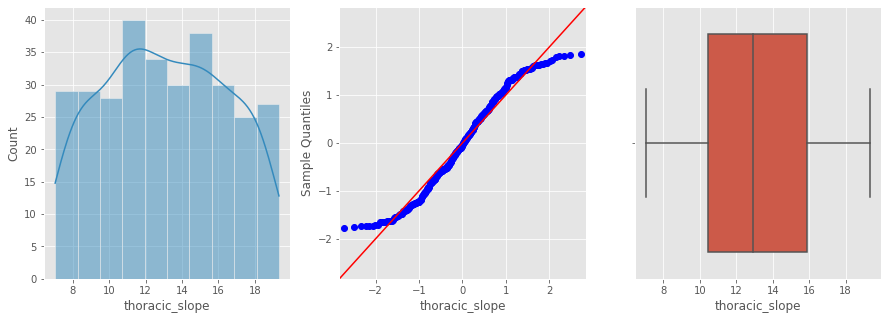

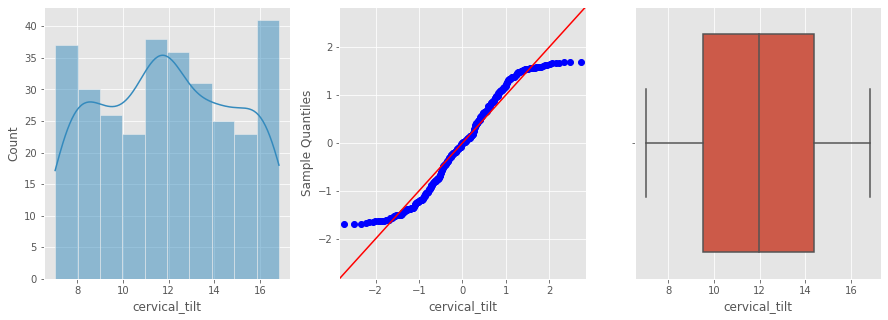

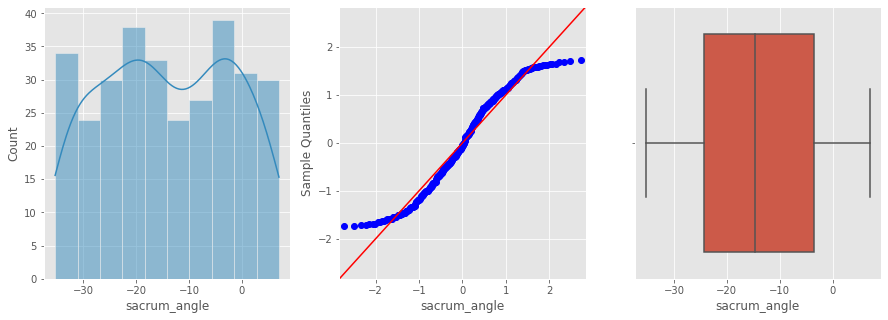

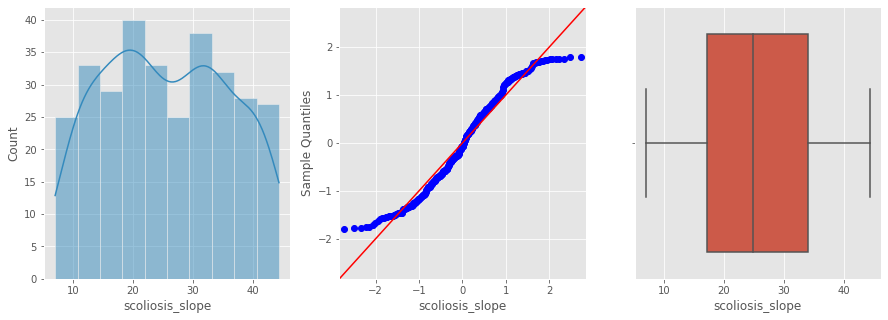

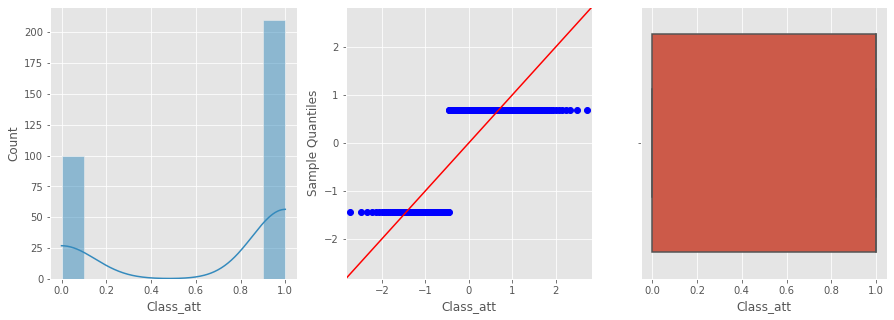

In [19]:
# Check for Normality - Visual Check - Plots not being saved.

for x in collst:
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
    sns.histplot(data=df,x=x,kde=True,ax=ax[0])
    sm.qqplot(df[x],ax=ax[1],line='45',fit=True)
    ax[1].set_xlabel(x)
    sns.boxplot(data=df,x=x,ax=ax[2])
    plt.show()

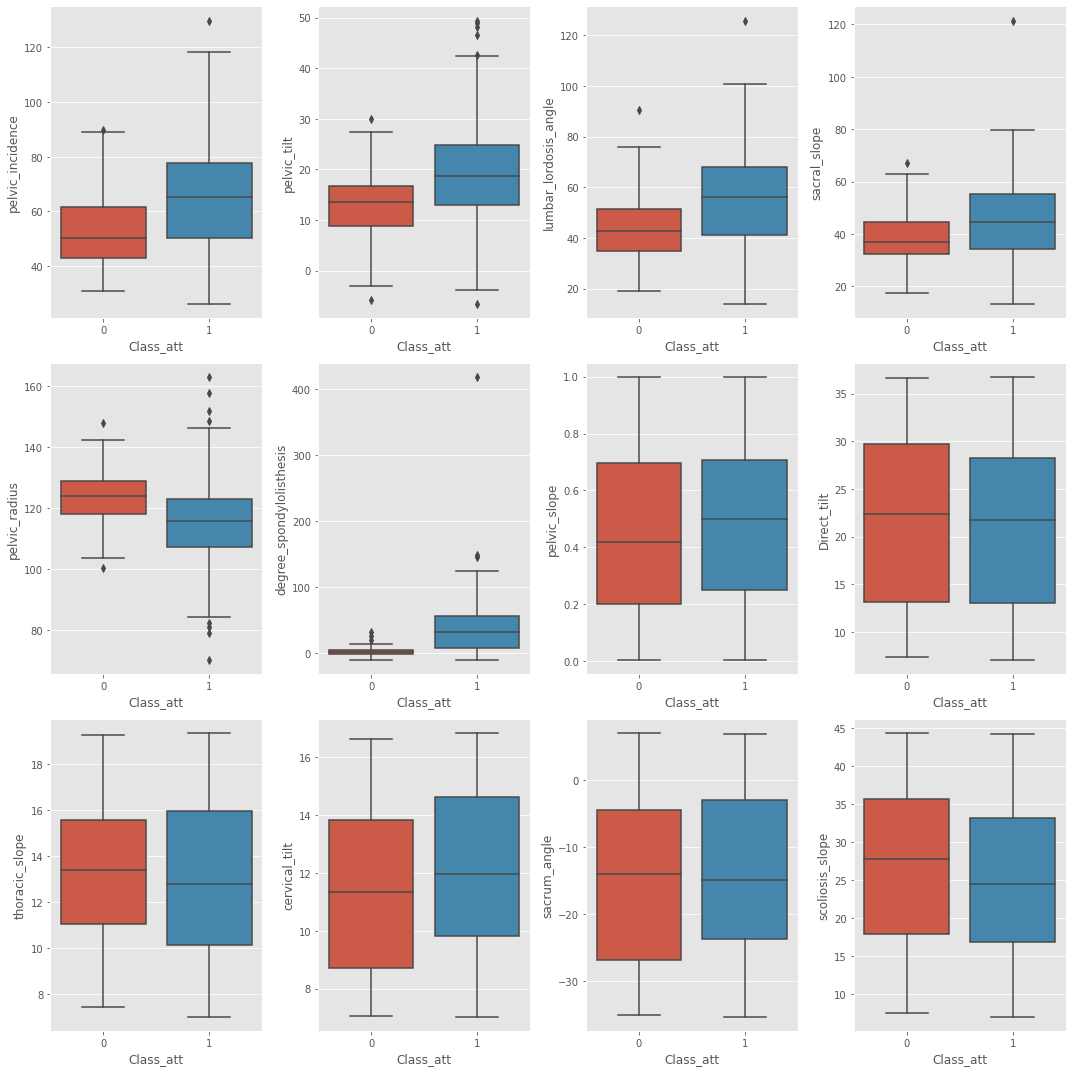

In [20]:
# Box Plot

if len(y_catlst)!= 0:
    NCOLS = 4
    m_rows = int(np.ceil((len(collst)-len(y_catlst))/NCOLS))
    fig, axes = plt.subplots(m_rows, NCOLS, figsize = (15,15))
    axes = axes.flatten()
    for lst in range(0, len(y_catlst), 1):
        temp = 'Fig_0' + str(lst)
        FIG1 = f"{temp}_Boxplot"
        for i in range(0,len(df.columns)-len(y_catlst)):
            sns.boxplot(x=y_catlst[lst], y=df.iloc[:,i], data=df, orient='v', ax=axes[i])
            plt.tight_layout()
            plt.savefig(f"{OUTPATH}{PREFIX}{FIG1}")

if len(y_catlst)== 0:
    FIG1 = r"Fig_01_Boxplot"
    lst = [x for x in collst if x not in y_catlst]
    fig, axes = plt.subplots(1, len(lst), figsize = (45,15))
    axes = axes
    for i, col in enumerate(lst):
        ax = sns.boxplot(y=df[col], ax=axes.flatten()[i])
        axminlt = df[col].min()-0.1*df[col].min()
        axmaxlt = df[col].max()+0.1*df[col].max()
        ax.set_ylim(axminlt, axmaxlt)
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.savefig(f"{OUTPATH}{PREFIX}{FIG1}")

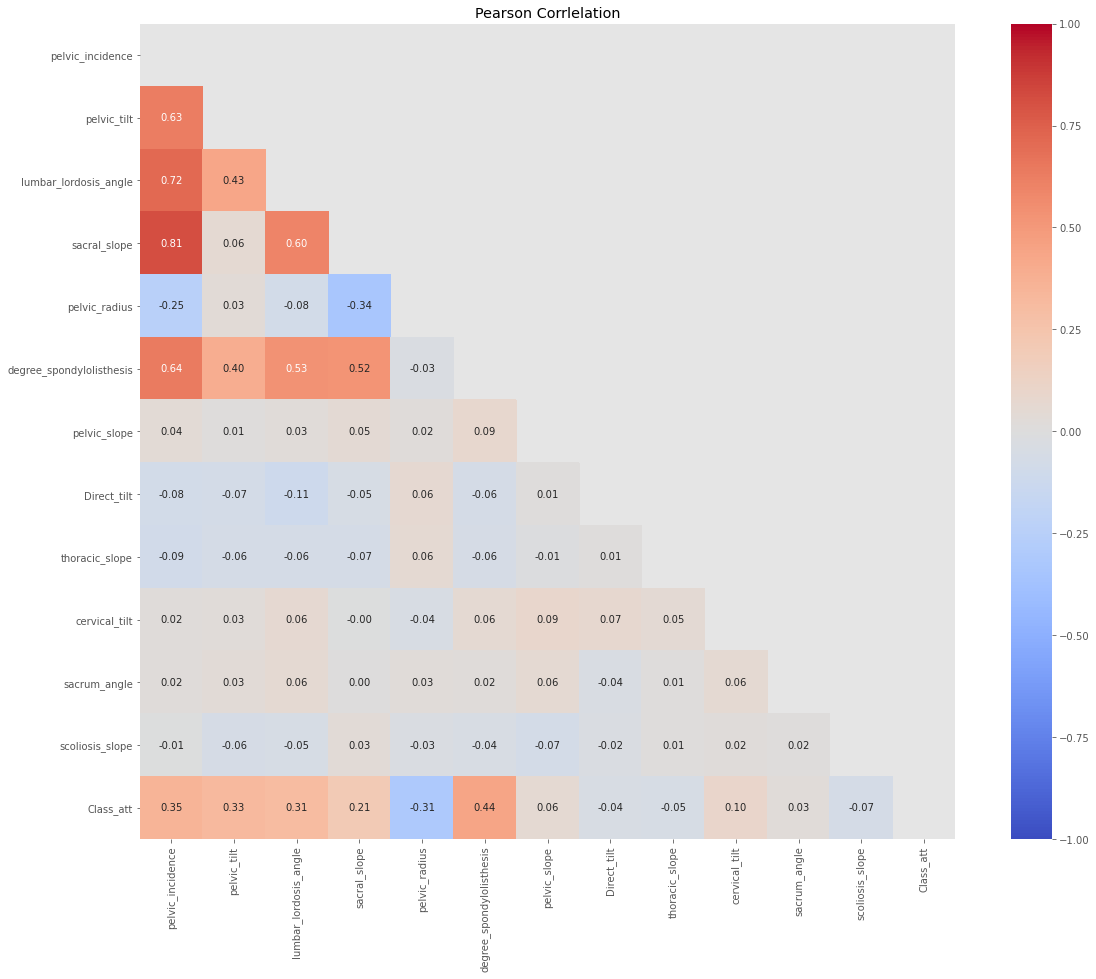

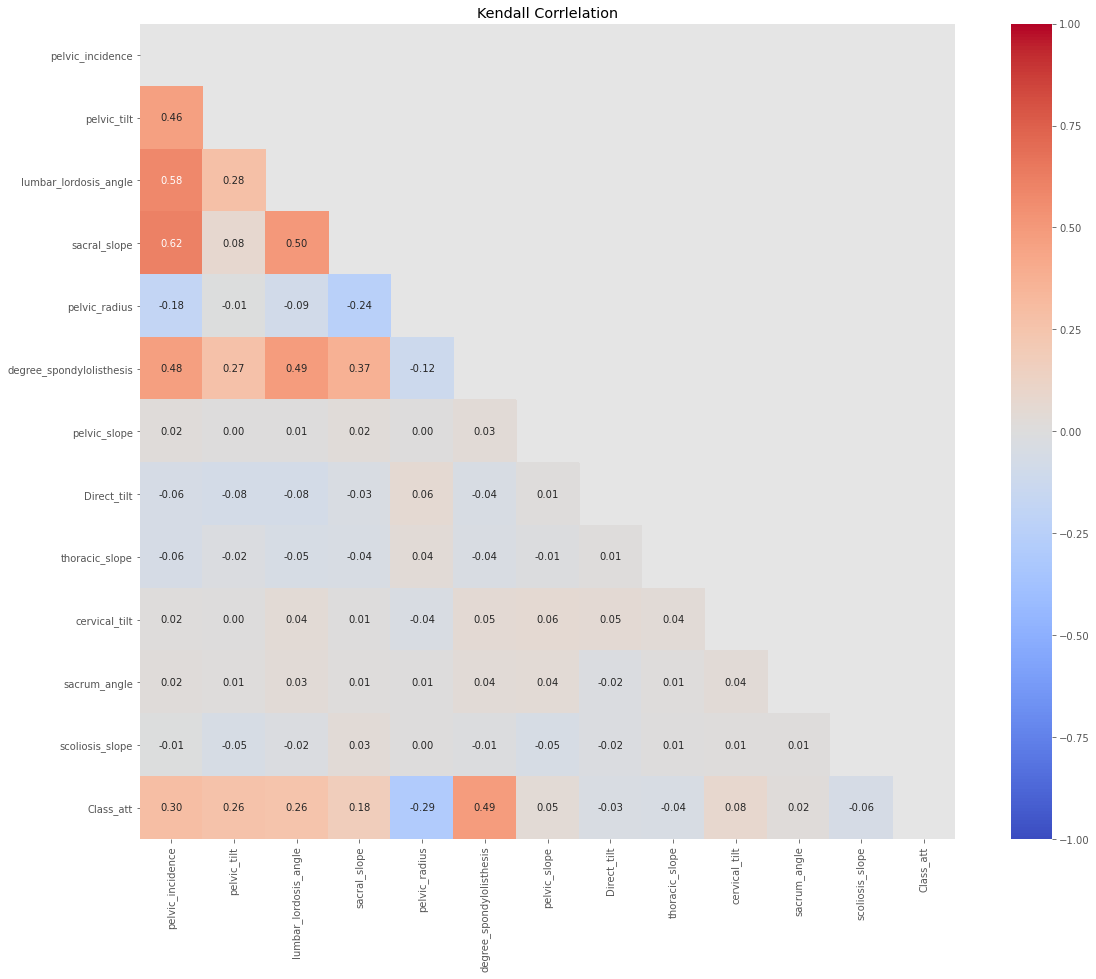

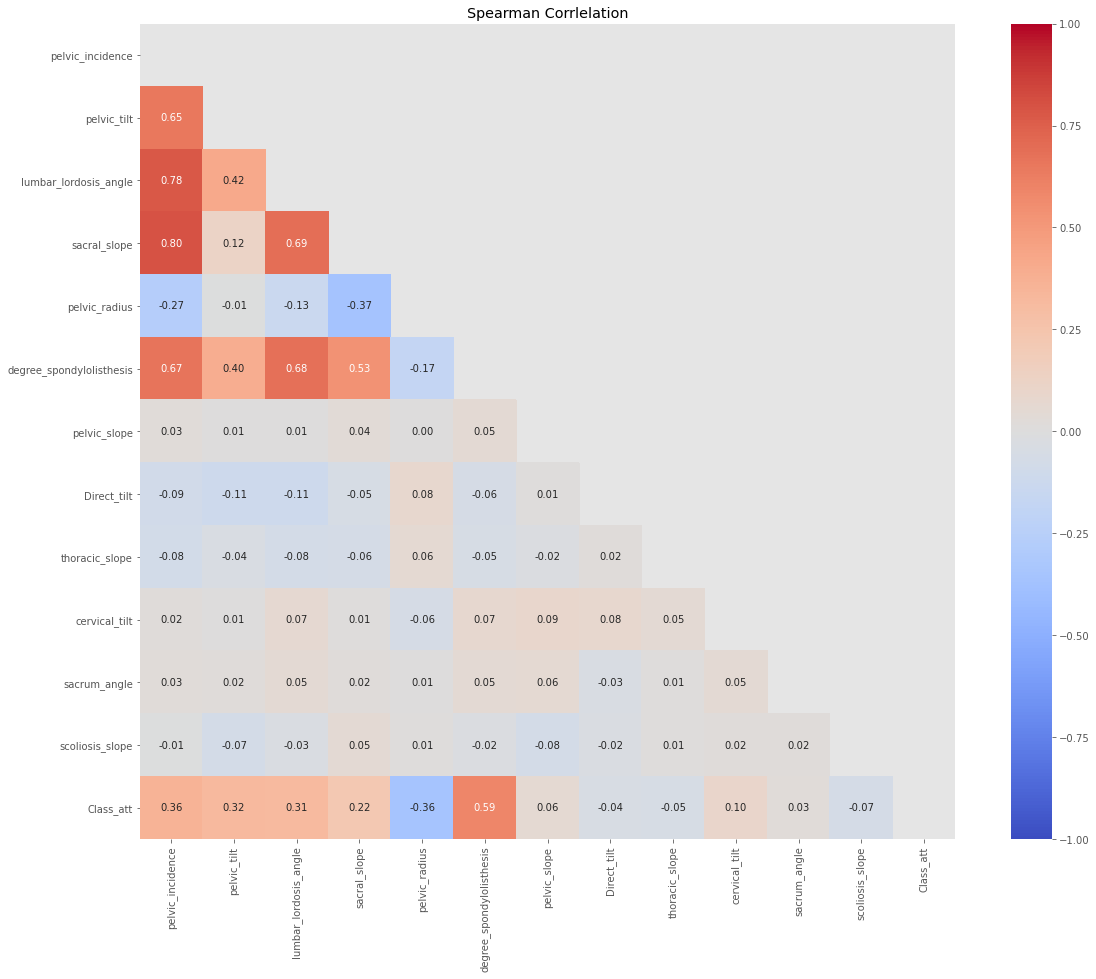

In [21]:
# Linear Correlation Heatmap

cormethod = {0:'pearson', 1:'kendall', 2:'spearman'}
for i in range(0, 3, 1):
    temp = 'linear_cor' + str(i)
    temp = df.corr(method=cormethod[i])
    ftemp = cormethod[i].title()
    FIG2 = r"Fig_02_Corr_"
    mask = np.zeros(temp.shape, dtype=bool)
    mask[np.triu_indices(len(mask))] = True
    plt.subplots(figsize=(20,15))
    plt.title(f"{ftemp} Corrlelation")
    sns.heatmap(temp, annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', square=True, mask=mask, fmt='.2f')
    plt.savefig(f"{OUTPATH}{PREFIX}{FIG2}{ftemp}")

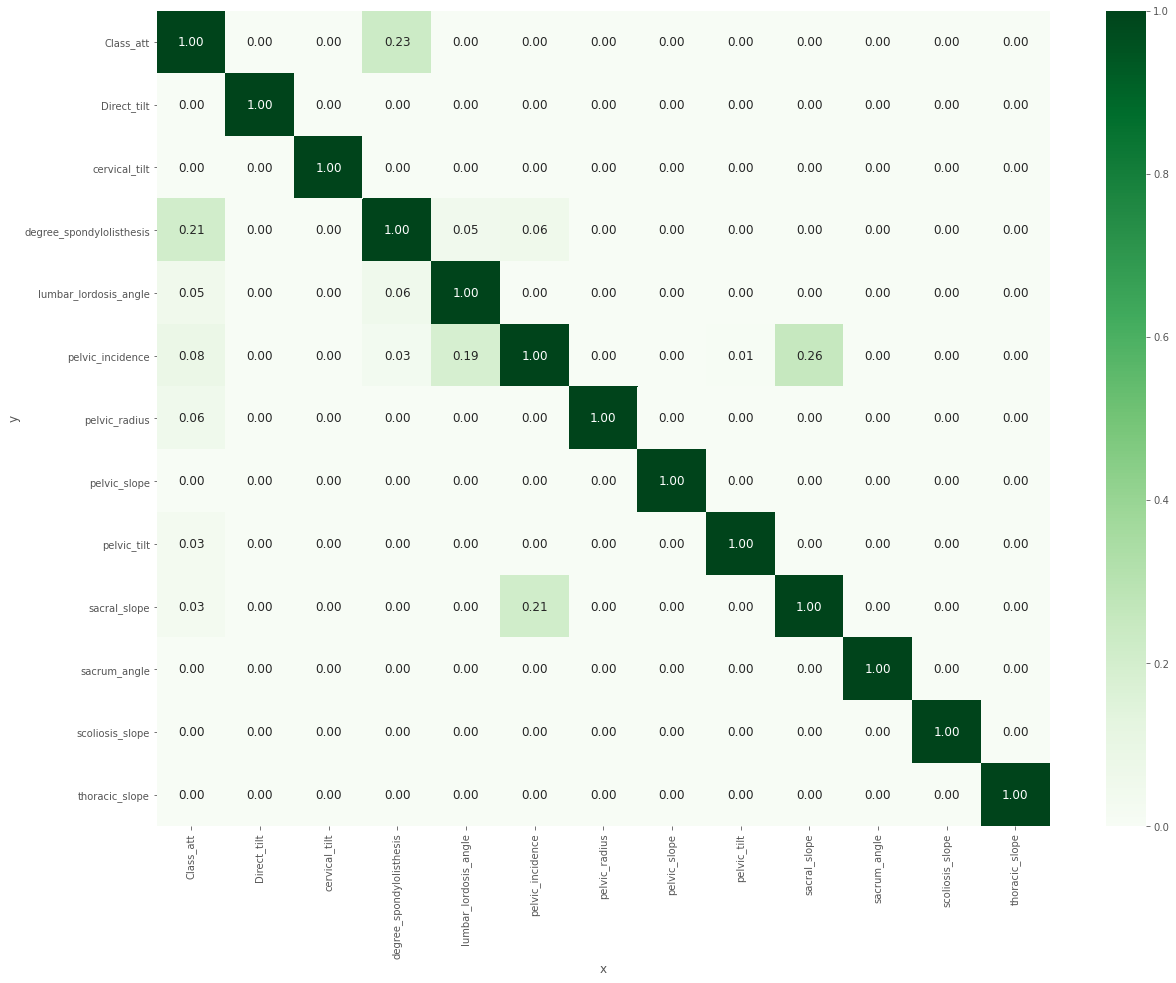

In [22]:
# Non-Linear Correlation Predictive Power Score - Heatmap

FIG3 = r"Fig_03_Predictive_Power_Score"

ppscorr = pps.matrix(df) # Predictive Power Score - PPS
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y',
                                                        values='ppscore')
plt.subplots(figsize=(20,15))
sns.heatmap(matrix_df, cmap="Greens", annot=True, linewidth=0, annot_kws={"size":12}, fmt='.2f')
plt.savefig(f"{OUTPATH}{PREFIX}{FIG3}")

In [23]:
# Feature Reduction -  Variance Inflation Factor [VIF]

vif_data = pd.DataFrame()
vif_data["Feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

In [24]:
print("------ Variance Inflation Factor ------")

------ Variance Inflation Factor ------


In [25]:
vif_data.head(100).round(2)

,Feature,VIF
0,pelvic_incidence,1.702684e+12
1,pelvic_tilt,1.754456e+11
2,lumbar_lordosis_angle,1.951000e+01
3,sacral_slope,8.714396e+11
4,pelvic_radius,3.530000e+01
5,degree_spondylolisthesis,2.660000e+00
6,pelvic_slope,3.830000e+00
7,Direct_tilt,7.280000e+00
8,thoracic_slope,1.526000e+01
9,cervical_tilt,1.733000e+01


In [ ]:
# Feature Reduction - Principal Component Analysis [PCA]

if n_target == 0:
    X = df.copy()
else:
    X = df.drop(columns=targlst)
    y = df.filter(targlst, axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Principal Component Analyses

sklpca = SKLPCA(n_components=0.95, svd_solver='full')
sklpca.fit(X_scaled)
X_transform = sklpca.transform(X_scaled)

pricom = pd.DataFrame(sklpca.components_.round(3)) # Principal Components
pricomvar = pd.DataFrame(sklpca.explained_variance_ratio_.round(3))

n_pca_comp = sklpca.n_components_
print("No. of Components Explaining 95% Variance:", n_pca_comp)

# Identifying Top Features of  PCA using pca module

model = pca(n_components=0.95, normalize=True, random_state=RND_STATE)
out = model.fit_transform(X)
pcatopfeat = out['topfeat'].round(3)

# Identifying Top Features of  PCA using pca module

model = pca(n_components=0.95, normalize=True, random_state=RND_STATE)
out = model.fit_transform(X)
pcatopfeat = out['topfeat'].round(3)

In [27]:
print("------ Top Principal Component ------")

------ Top Principal Component ------


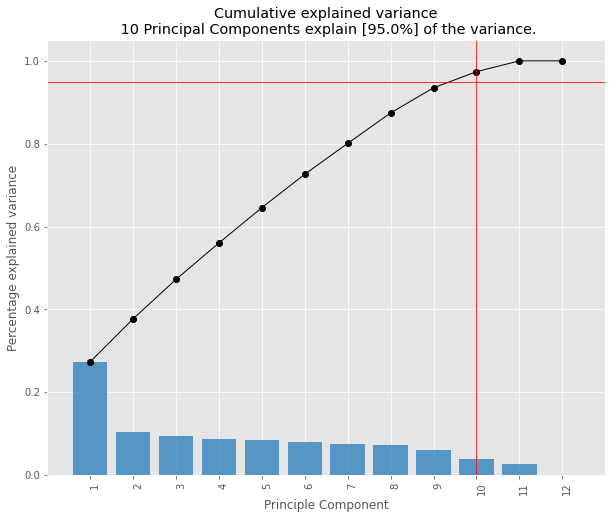

<Figure size 432x288 with 0 Axes>

In [28]:
FIG4 = r"Fig_04_PCA_Model_Plot"
fig, ax = model.plot()
ax.figure.savefig(f"{OUTPATH}{PREFIX}{FIG4}")

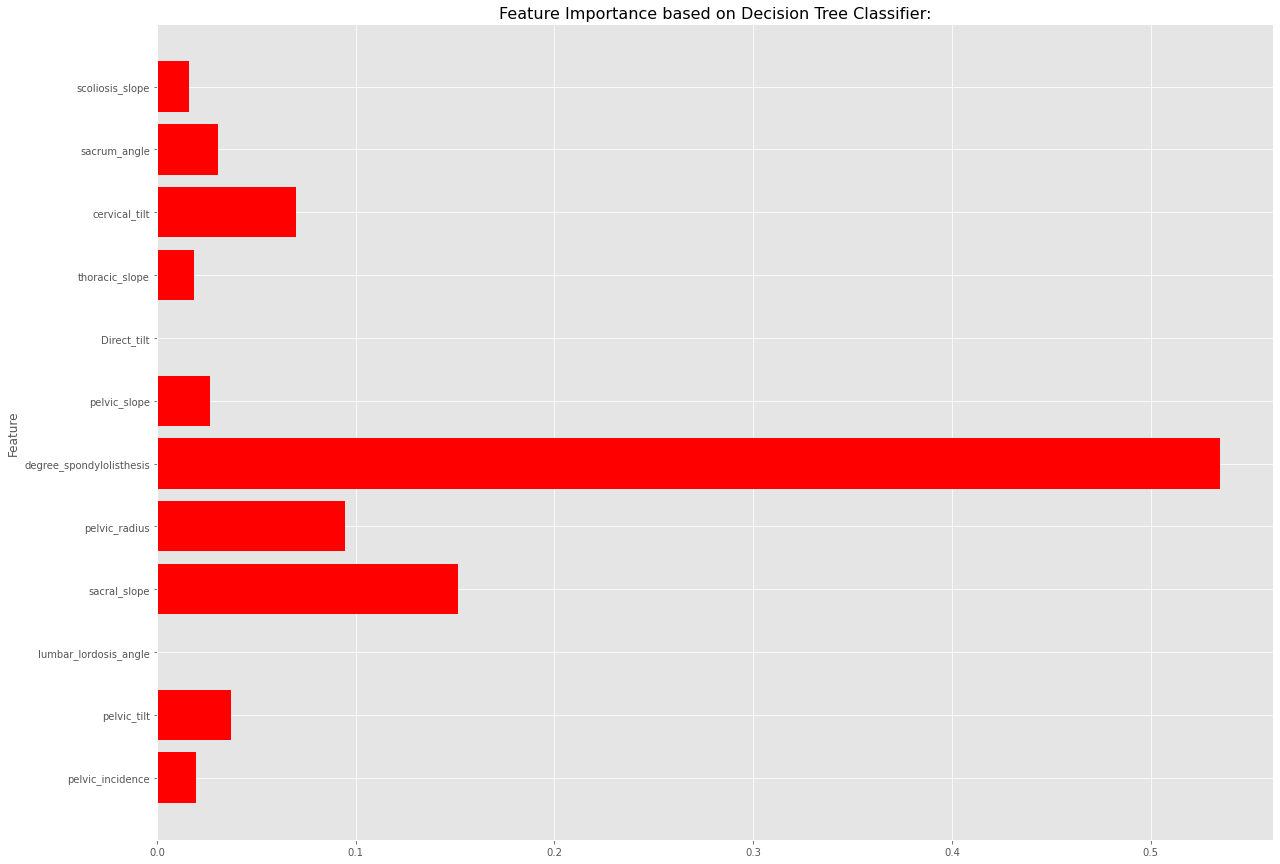

In [29]:
# Feature Importance - Decision Tree Classifier

FIG44 = r"Fig_44_Feature_Importance"

if n_target != 0:
    X = df.drop(columns=targlst)
    y = df.drop(columns=featlst)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE,
                                                        random_state=RND_STATE)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    MLM_DTR = DecisionTreeClassifier(max_depth=5, random_state=RND_STATE)
    MLM_DTR.fit(X_train, y_train)
    feat_imp = MLM_DTR.feature_importances_.round(3)
    colhead = X.columns.tolist()
    featimp = pd.DataFrame(np.column_stack([colhead, feat_imp]), columns=['Features',
                                                                          'Coefficients'])
    featimp = featimp.sort_values('Coefficients', ascending=False)
else:
    featimptemp = {'Features':[np.nan], 'Coefficients':[np.nan],
                   'Remarks':['Unsupervised Learning']}
    featimp = pd.DataFrame(featimptemp, columns=['Features',
                                                 'Coefficients', 'Remarks'])

plt.figure(figsize=(20, 15))
plt.yticks(range(0, len(featlst)), featlst)
plt.barh(range(0, len(featlst)), MLM_DTR.feature_importances_, color='red', align='center')
plt.ylabel('Feature', fontsize=12)
plt.title("Feature Importance based on Decision Tree Classifier:", fontsize=16)
plt.savefig(f"{OUTPATH}{PREFIX}{FIG44}")

Top Features: ['degree_spondylolisthesis', 'sacral_slope', 'pelvic_radius', 'cervical_tilt', 'pelvic_tilt', 'sacrum_angle', 'pelvic_slope', 'pelvic_incidence']


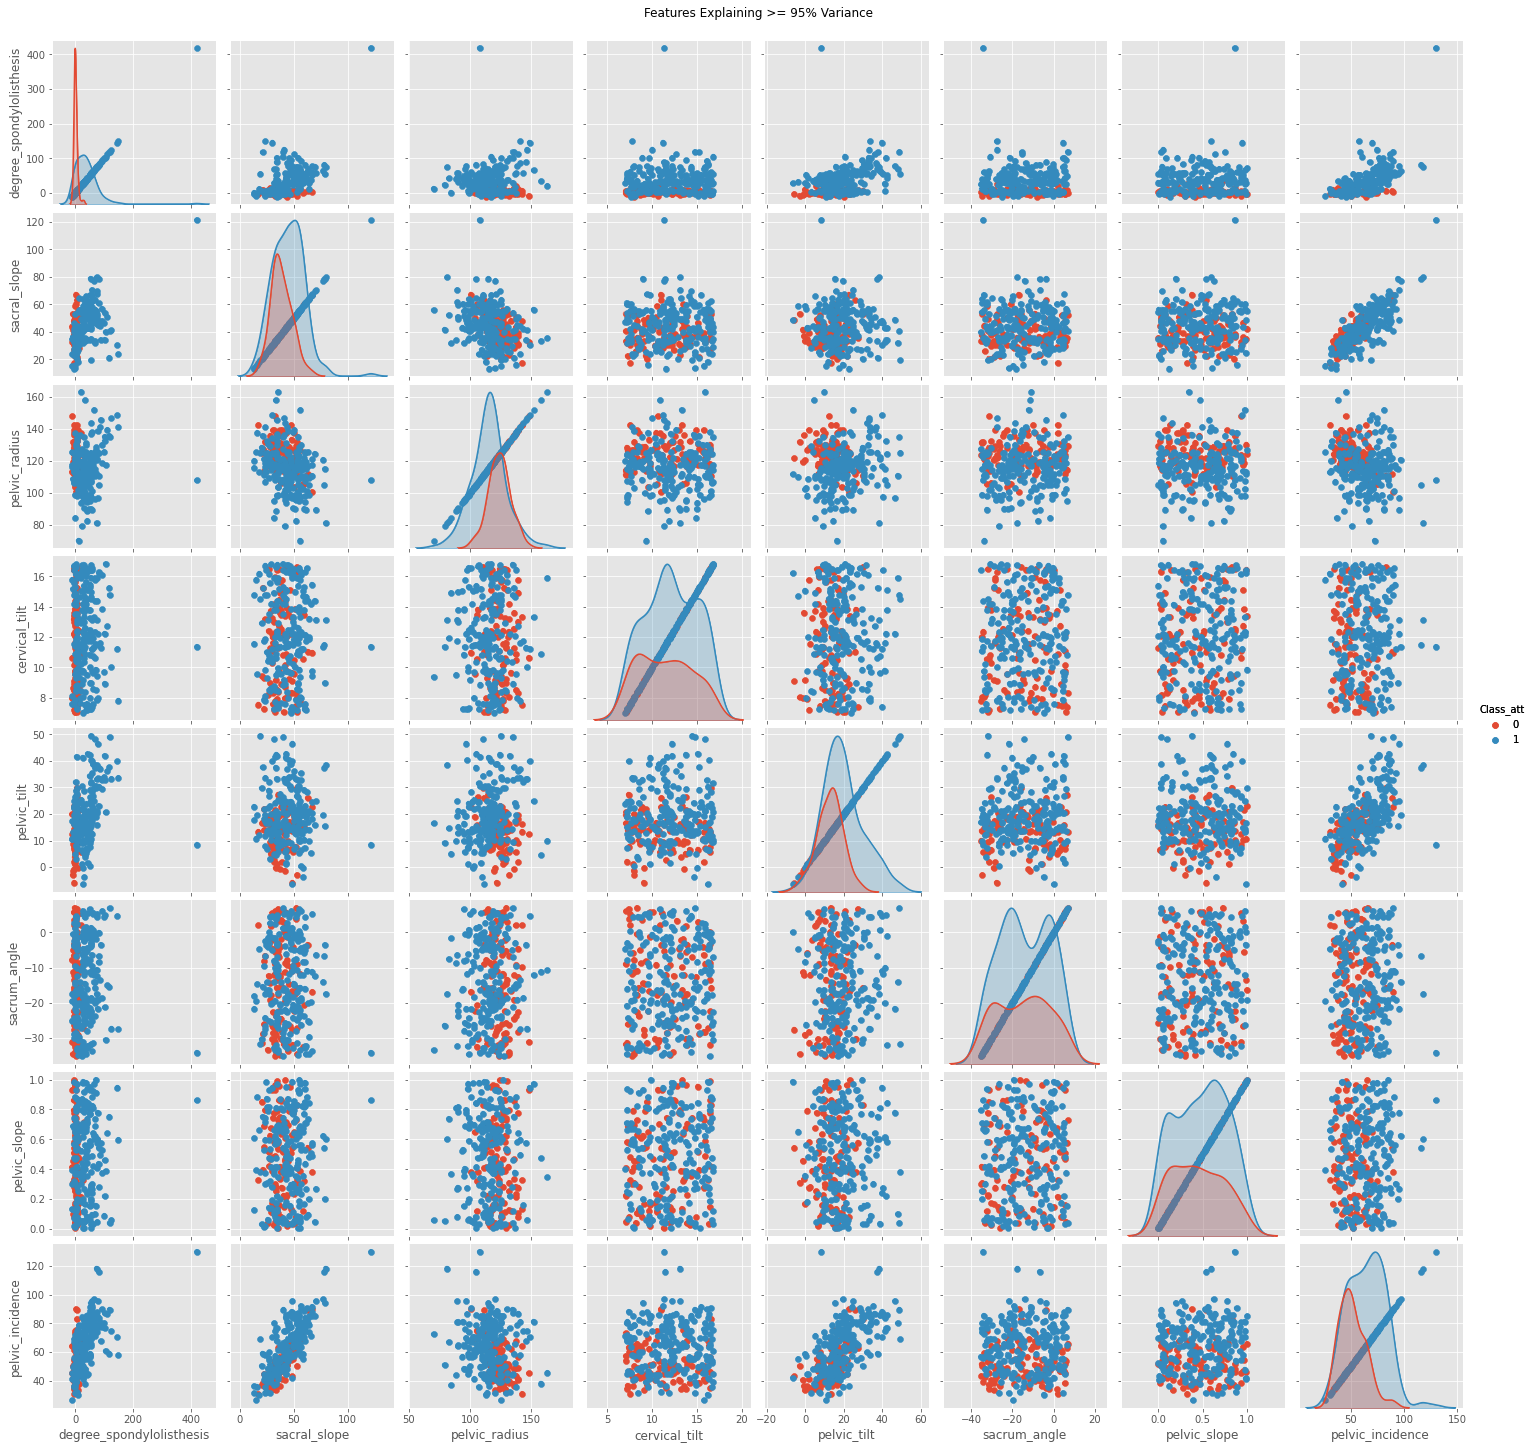

In [30]:
# Scatter Plot of Top Features of Importance from DTR

FIG5 = r"Fig_05_Scatter_Plot"

temp = featimp["Coefficients"].to_numpy()

cumsum = 0
for i in range(0, len(temp), 1):
    cumsum = cumsum + float(temp[i])
    if cumsum >= 0.95:
        break
    else:
        continue

n_crit_feat = i

DTR_featlst = featimp['Features'].to_list()
topfeat = []
for i in range(0, n_crit_feat+1, 1):
    topfeat.append(DTR_featlst[i])
print("Top Features:", topfeat, end='\n')

topfeat.extend(targlst) # Adding target variables to topfeatures

df_scatter = df.filter(topfeat, axis=1)
grid1 = sns.pairplot(df_scatter, hue='Class_att')
grid1.map(plt.scatter)
grid1.map_diag(sns.kdeplot)
grid1.add_legend()
grid1.fig.suptitle("Features Explaining >= 95% Variance", y=1.01)
grid1.savefig(f"{OUTPATH}{PREFIX}{FIG5}")

In [31]:
# EDA Report Out

# Output to Excel

SUMMARY = r"00_Results_Summary.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{SUMMARY}", engine='xlsxwriter', options={'strings_to_numbers': True})
DF_INFO.to_excel(writer, sheet_name='Info')
desc_stat.to_excel(writer, sheet_name='Stats')
vif_data.to_excel(writer, sheet_name='VIF')
pricomvar.to_excel(writer, sheet_name='PCA_VAR')
pricom.to_excel(writer, sheet_name='PCA_Components')
pcatopfeat.to_excel(writer, sheet_name='PCA_Top_Features')
featimp.to_excel(writer, sheet_name='DTR-Features')
writer.save()

### Conclusions & Recommendations

Conclusions:

    1. Encoding: Normal = 0 | Abnormal (Patient) = 1
    2. No missing values. No imputing is needed.
    3. Normal : Anbormal :: 100 : 210.
    4. Features have a mix of negative and positive values.
    5. Features do not follow normal distribution strictly.
    6. Few outliers exist.
    7. Fair degree of linear separability exists.
    8. Pelvic radius inversely related to Class_att.
    9. Pelvic incidence has high correlation. A closer look shows that:
        - pelvic_incidence = pelvic_tilt + sacral_slope
    10. Needless to say, VIF is quiet high for some features indicating very high degree of multi-colliniarity.
    11. 10 / 12 components are needed to explain 95% variance.
    12. Top features explaining 95% variance in output based on Decision Tree:
        ['degree_spondylolisthesis', 'sacral_slope', 'pelvic_radius', 'cervical_tilt', 'pelvic_tilt', 'sacrum_angle',
        'pelvic_slope', 'pelvic_incidence']

Recommendations:
    
    1. Remove pelvic incidence from model developement.
    2. StandardScaler might be better than MinMaxScaler.
    3. If desired accuracy is not achieved with the full dataset, it makes sense to go for downsampling.


In [34]:
!jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" EDA_FE_CLF_Dataset_Back_Pain.ipynb --to html

[NbConvertApp] Converting notebook EDA_FE_CLF_Dataset_Back_Pain.ipynb to html
[NbConvertApp] Writing 2751382 bytes to C:\DSML_Case_Studies\01_Classification\00_Final_Reports\EDA_FE_CLF_Dataset_Back_Pain.html
